# Data Retrieval from ebay API
https://developer.ebay.com/devzone/finding/CallRef/index.html#CallIndex

## Get Request to ebay API

In [1]:
from ebaysdk.finding import Connection

In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle

In [3]:
api = Connection(config_file='ebay.yaml', siteid="EBAY-US")

In [4]:
%%time
outputs = []
for sio in [False, True]:
    output = []
    for i in range(20):
        request_complete = {
            'categoryId': '9355', # cellphone  
            'keywords': 'iphone',
            'itemFilter': [
                {'name': 'Currency', 'value': 'USD'},
                {'name': 'ListingType', 'value': 'FixedPrice'},
                {'name': 'EndTimeTo', 'value': '2019-10-25T00:00:00.000Z'}, #bids ending by October 25th. Month ends tend to have too many refurbished product.
                {'name': 'SoldItemsOnly', 'value': sio},
            ],
            'paginationInput': {
                    'entriesPerPage': 100,
                    'pageNumber': i+1
                },
            'HideDuplicateItems': True,
        }
        response_complete = api.execute('findCompletedItems', request_complete)
        print(f'SoldItemsOnly: {sio}, Page {i+1}: {len(response_complete.reply.searchResult.item)} results found.')
        output += response_complete.reply.searchResult.item
    outputs += [output]

SoldItemsOnly: False, Page 1: 100 results found.
SoldItemsOnly: False, Page 2: 100 results found.
SoldItemsOnly: False, Page 3: 100 results found.
SoldItemsOnly: False, Page 4: 100 results found.
SoldItemsOnly: False, Page 5: 100 results found.
SoldItemsOnly: False, Page 6: 100 results found.
SoldItemsOnly: False, Page 7: 100 results found.
SoldItemsOnly: False, Page 8: 100 results found.
SoldItemsOnly: False, Page 9: 100 results found.
SoldItemsOnly: False, Page 10: 100 results found.
SoldItemsOnly: False, Page 11: 100 results found.
SoldItemsOnly: False, Page 12: 100 results found.
SoldItemsOnly: False, Page 13: 100 results found.
SoldItemsOnly: False, Page 14: 100 results found.
SoldItemsOnly: False, Page 15: 100 results found.
SoldItemsOnly: False, Page 16: 100 results found.
SoldItemsOnly: False, Page 17: 100 results found.
SoldItemsOnly: False, Page 18: 100 results found.
SoldItemsOnly: False, Page 19: 100 results found.
SoldItemsOnly: False, Page 20: 100 results found.
SoldItems

In [5]:
pickle_out = open("outputfile_dict","wb")
pickle.dump(outputs, pickle_out)
pickle_out.close()

outputs

[[{'itemId': '153679315815', 'title': 'Apple iPhone 6s, 16GB, White For Sprint Phones. Works perfectly.', 'globalId': 'EBAY-US', 'primaryCategory': {'categoryId': '9355', 'categoryName': 'Cell Phones & Smartphones'}, 'galleryURL': 'https://thumbs4.ebaystatic.com/m/mYWqOj1n5a-Wg44-ttezXsw/140.jpg', 'viewItemURL': 'https://www.ebay.com/itm/Apple-iPhone-6s-16GB-White-Sprint-Phones-Works-perfectly-/153679315815', 'productId': {'_type': 'ReferenceID', 'value': '240420050'}, 'paymentMethod': 'PayPal', 'autoPay': 'true', 'postalCode': '802**', 'location': 'Denver,CO,USA', 'country': 'US', 'shippingInfo': {'shippingServiceCost': {'_currencyId': 'USD', 'value': '7.0'}, 'shippingType': 'Flat', 'shipToLocations': 'Worldwide', 'expeditedShipping': 'true', 'oneDayShippingAvailable': 'false', 'handlingTime': '2'}, 'sellingStatus': {'currentPrice': {'_currencyId': 'USD', 'value': '75.0'}, 'convertedCurrentPrice': {'_currencyId': 'USD', 'value': '75.0'}, 'sellingState': 'Ended'}, 'listingInfo': {'best

In [6]:
# pickle_in = open("outputfile_dict","rb")
# outputs = pickle.load(pickle_in)

## Putting data into pandas dataframe and preprocess

1. Removal of records with duplicative ID (latest record remained)
2. Add a column for iPhone type
3. Add a column for iPhone disk size
4. Removal of records with None on iphoneType column or iphoneDiskSize column
5. Add a column for indicator of unlocked (sim free)
6. Add a column for duration by sales or cancel in days
7. Add a column for total price which is sum of price and shipping cost
8. Select necessary columns

In [7]:
#some record does not have shipping cost. Then, use $0.
def catch(func, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return 0.0
    
def organize_output(o):
    outputs_organized = {
        'id': [oi.itemId for oi in o],
        'name': [oi.title for oi in o],
        'shippingcost': [catch(lambda: float(oi.shippingInfo.shippingServiceCost.value)) for oi in o],
        'price': [float(oi.sellingStatus.currentPrice.value) for oi in o],
        'starttime': [oi.listingInfo.startTime for oi in o],
        'endtime': [oi.listingInfo.endTime for oi in o],
        'condition': [oi.condition.conditionDisplayName for oi in o],
    }
    return outputs_organized

In [28]:
df_all, df_solditem = pd.DataFrame.from_dict( organize_output(outputs[0]) ), pd.DataFrame.from_dict( organize_output(outputs[1]) )

# Remove dups in id.
df_all.drop_duplicates(subset ="id", keep = 'first', inplace = True)
df_solditem.drop_duplicates(subset ="id", keep = 'first', inplace = True)
print(df_all.shape)

# Set sold flag
df_solditem = df_solditem[['id','endtime']]
df_final = df_all.join(df_solditem.set_index('id'), on='id', lsuffix='', rsuffix='_r')
df_final['sold'] = pd.isna(df_final['endtime_r'])
df_final['sold'] = 1 - df_final['sold']
df_final.drop(['endtime_r'],axis=1,inplace=True)

# Add iphone type column
def iphoneType(s):
    ls = s.lower().split()
    try:
        t1 = ls[ls.index('iphone')+1].replace(',','').replace('+','plus')
        p = ls[ls.index('iphone')+2].replace(',','')
        if p == 'plus' or p == '+': 
            t2 = 'plus'
        else: 
            t2 = ''
        return t1+t2
    except:
        return None
df_final['iphoneType'] = df_final['name'].map(iphoneType)

# Manual adjustment to iPhone type
conv = {
    '7plusplus': '7plus',
    '10s': 'xs',
    '7/7plus': '7',
    '8plusplus': '8plus',
    '5-': '5',
    '7-32gb': '7',
    '11-': '11',
    'eightplus': '8plus', 
    '6-16gb': '6',
    '7s': '7',
    'pro': '11',
    'blue': '11',
    '6se': '6s',
    'ten': 'x',
    'xs/max': 'xs',
    'se-t-mobile-space': 'se',
    '4-unlocked-verizon-sprint-8gb16gb32gb-mint': '4',
    'ten-r': 'xr',
    'xr-': 'xr',
}
def convType(t):
    if t in conv.keys():
        return conv[t]
    return t
df_final['iphoneType'] = df_final['iphoneType'].map(convType)

# Add iphone disk size column
def iphoneDiskSize(s):
    try:
        return int(re.search('\d+\s*gb',s.lower()).group()[:-2])
    except:
        return None
df_final['iphoneDiskSize'] = df_final['name'].map(iphoneDiskSize)
df_final = df_final[(df_final['iphoneDiskSize']!=2.0) & (df_final['iphoneDiskSize']!=18.0)]
print(df_final.shape)

# Remove records with None for iphoneType or iphoneDiskSize
df_final = df_final.dropna(subset=['iphoneType', 'iphoneDiskSize'])
print(df_final.shape)

# Add unlocked flag
def check_unlock(s):
    if ('unlock' in s.lower() or 'simfree' in s.lower() or 'sim free' in s.lower()):
        return 1
    return 0
df_final['unlocked'] = df_final.name.map(check_unlock)

# Duration by days
df_final['dur'] = df_final['endtime'] - df_final['starttime']
df_final['dur'] = df_final['dur'].map(lambda x: x.days + x.seconds/(24*60*60))
df_final = df_final.query('dur>0')
print(df_final.shape)

# Total price = price + shipping cost
df_final['tot_price'] = df_final['shippingcost'] + df_final['price']

# Final data
df_final = df_final[['condition','sold','iphoneType','iphoneDiskSize','unlocked','dur','tot_price']].reset_index(drop=True)

pickle_out = open("outputfile_df_final","wb")
pickle.dump(df_final, pickle_out)
pickle_out.close()

df_final.to_csv('outputfile_df_final.csv',index=False)

df_final

(1367, 7)
(1364, 10)
(1256, 10)
(1254, 12)


,condition,sold,iphoneType,iphoneDiskSize,unlocked,dur,tot_price
0,Used,1,6s,16.0,0,14.690532,82.00
1,Used,1,4s,16.0,0,1.121111,14.00
2,Used,1,x,256.0,1,10.057535,580.00
3,Open box,1,8plus,64.0,1,0.005613,450.00
4,Used,1,6plus,16.0,0,2.910961,117.50
...,...,...,...,...,...,...,...
1249,Used,1,x,64.0,1,0.023519,425.00
1250,Used,1,xr,64.0,0,25.348646,380.00
1251,Open box,1,x,64.0,0,3.371227,480.00
1252,New,0,11,256.0,0,1.090197,1349.99


### A Quick EDA

***************** condition *****************
 Used                        569
For parts or not working    266
Seller refurbished          139
New                         132
Open box                     76
Manufacturer refurbished     72
Name: condition, dtype: int64 

***************** sold *****************
 1    924
0    330
Name: sold, dtype: int64 

***************** iphoneType *****************
 7         143
x         117
8plus     111
xs        111
6s        106
6         101
7plus      97
xr         81
8          76
11         69
se         52
6splus     49
5s         38
6plus      32
5          30
5c         18
4           8
4s          5
3g          4
3gs         3
1st         3
Name: iphoneType, dtype: int64 

***************** iphoneDiskSize *****************
 64.0     472
32.0     234
16.0     219
256.0    170
128.0    122
8.0       22
512.0     15
Name: iphoneDiskSize, dtype: int64 

***************** unlocked *****************
 1    643
0    611
Name: unlocked, dtype: 

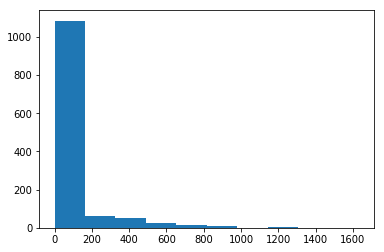

***************** tot_price *****************


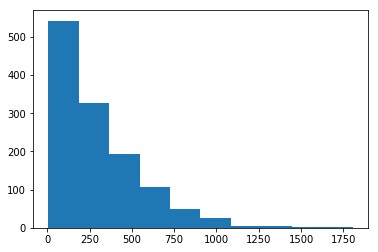

In [29]:
col = df_final.columns
for i in range(5):
    print('*****************',col[i],'*****************\n',df_final[col[i]].value_counts(),'\n')
print('*****************',col[5],'*****************');plt.hist(df_final[col[-2]]);plt.show()
print('*****************',col[6],'*****************');plt.hist(df_final[col[-1]]);plt.show()

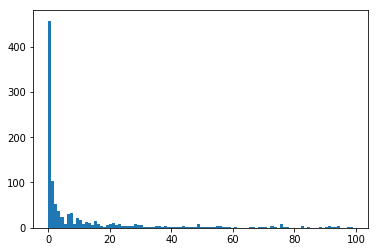

In [30]:
plt.hist(df_final[col[-2]][df_final[col[-2]]<=100],bins=100);plt.show()